#LSTM and Bi-LSTM for Precipitation Prediction


In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,TimeDistributed
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from keras import layers
from google.colab import files
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
sns.set_style("darkgrid")
# mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv(r'/content/drive/MyDrive/LSTM and Bi-LSTM/Daily Abidjan_data.csv')

df_input= df[['PREC','T2M', 'WS2M', 'QV2M', 'RH2M', 'PS','SWRD']].sort_index()
scaler=MinMaxScaler()
data_scaled=scaler.fit_transform(df_input)

####################Datapreprocessing For precipitation########################

# define X and Y
target=data_scaled[:,0]
features= data_scaled
features_num=7
# Data splitting
X_train,  y_train = features[:1636,:], target[:1636]
X_val,y_val= features[1636:2045,:], target[1636:2045]
X_test,y_test= features[2045:,:], target[2045:]


In [ ]:
# [*zip([20,50,80],[24,32,64])]
# import itertools
#Creating list to contain the columns
ls=[]
for wl in [20,50,80]:
  for bs in [24,32,64]:
    ls.append((wl,bs))
ls
# list(itertools.combinations(sl, bs))

In [47]:
# dat=pd.DataFrame(index=["mse", "r2","mae","mape","mpe"])
# ls1=list()
# i=0
# for window_length,b_size in ls:
#   # ls1.append("window_length:{} & b_size:{}".format(window_length,b_size))
#   dat.loc[:,"window_length:{} & b_size:{}".format(window_length,b_size)]=list("abcde")
#   # i+=1

In [ ]:
dat

LSTM


In [ ]:
########################################################################################################################
#####################################   LSTM model for   Precipitation prediction       ###############################
########################################################################################################################
data=pd.DataFrame(index=["MSE", "R2","MAE","MAPE","SMAPE","MASE"])
for window_length,b_size in ls:
  # ls1.append("window_length:{} & b_size:{}".format(window_length,b_size)):# Data transformation in supervised data using sliding window method
  # i+=1
  features_num=7
  train_generator= TimeseriesGenerator(X_train,y_train,length=window_length,sampling_rate=1,batch_size=b_size)
  val_generator= TimeseriesGenerator(X_val,y_val,length=window_length,sampling_rate=1,batch_size=b_size)
  test_generator= TimeseriesGenerator(X_test,y_test,length=window_length,sampling_rate=1,batch_size=b_size)
  model=Sequential()
  model.add(LSTM(12, activation='relu', input_shape=(window_length, features_num), return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(1))

  model.summary()

  # Early stopping: Model stops if the validation loss does not improve after 3 more iteration the algorithm stop
  early_stopping= tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=45,mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),optimizer='adam',metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.RootMeanSquaredError()])
  history=model.fit(train_generator,epochs=50,shuffle=False, validation_data=val_generator,callbacks=[early_stopping])
  # Evaluation pof MSE with the test_generator
  model.evaluate(test_generator,verbose=0)

  # Predictions
  predictionsp=model.predict(test_generator)
  # Consider the values of X_test by ignoring the first 14th
  New_X_testp=X_test[:,1:][window_length:]

  # Datapredicted
  df_predp=pd.concat([pd.DataFrame(predictionsp),pd.DataFrame(New_X_testp)],axis=1)
  # return the inverse transform of the MinMaxscaler created above to give the real value that we had initially
  rev_transp=scaler.inverse_transform(df_predp)

  # Dysplay the prediction set
  df_finalp=df_input[-predictionsp.shape[0]:]
  #train 
  df_finaltrp=df_input[:-predictionsp.shape[0]]
  d_tr=df_finaltrp['PREC']
  df1p=df_finalp['PREC']
  rev2p=rev_transp[:,0]
  from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error

  # Performance metrics

  mse = mean_squared_error(df1p, rev2p)
  r2 = r2_score(df1p, rev2p)
  mae = mean_absolute_error(df1p, rev2p)
  mape = mean_absolute_percentage_error(df1p, rev2p)
  def MASE(d_tr, df1p, rev2):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    # print "Needs to be tested."
    n = d_tr.shape[0]
    d = np.abs(  np.diff( d_tr) ).sum()/(n-1)
    
    errors = np.abs(df1p - rev2 )
    return errors.mean()/d
  mase=MASE(d_tr, df1p, rev2p)
  # SMAPE 
  def smape(a, f):
    return (1/a.size * np.sum(np.abs(f-a) / (np.abs(a) + np.abs(f))*100))
  smape=smape(rev2p, df1p)
  data.loc[:,"window_length:{} & b_size:{}".format(window_length,b_size)]=[mse, r2,mae,mape,smape,mase]
  # print("mse=", msep)
  # print("r2=",r2p)
  # print("mae=",maep)
  # print("mape=" ,mapep)

In [54]:
data

,window_length:20 & b_size:24,window_length:20 & b_size:32,window_length:20 & b_size:64,window_length:50 & b_size:24,window_length:50 & b_size:32,window_length:50 & b_size:64,window_length:80 & b_size:24,window_length:80 & b_size:32,window_length:80 & b_size:64
MSE,2.471137e+01,2.526904e+01,2.552048e+01,2.482427e+01,2.711197e+01,2.702312e+01,2.387418e+01,2.444157e+01,2.442993e+01
R2,2.106943e-01,1.928817e-01,1.848506e-01,2.312039e-01,1.603549e-01,1.631066e-01,1.842386e-01,1.648514e-01,1.652491e-01
MAE,3.150812e+00,3.241904e+00,3.233308e+00,3.261846e+00,3.296722e+00,3.291843e+00,3.210780e+00,3.221456e+00,3.125366e+00
MAPE,9.396835e+13,7.707533e+13,6.458294e+13,7.440105e+13,7.520300e+13,6.627588e+13,9.234753e+13,1.068642e+14,7.446221e+13
SMAPE,3.545971e+01,3.567536e+01,3.620700e+01,3.634470e+01,3.647166e+01,3.641449e+01,3.742896e+01,3.794936e+01,3.667372e+01
MASE,1.134479e+00,1.167278e+00,1.164182e+00,1.178112e+00,1.190709e+00,1.188946e+00,1.148205e+00,1.152023e+00,1.117660e+00


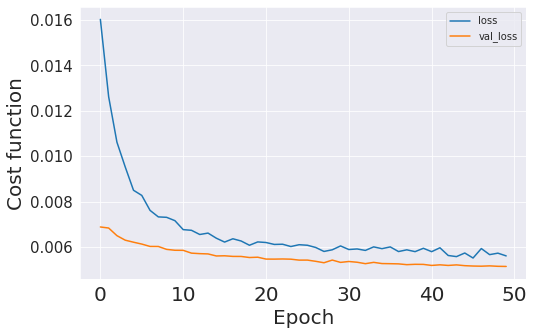

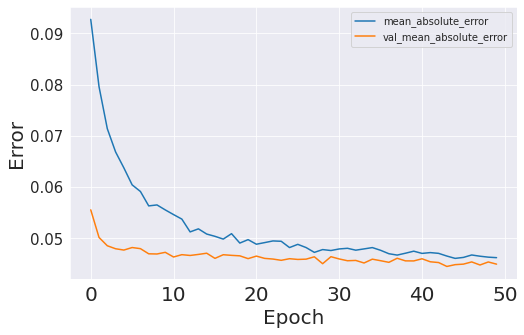

In [57]:
# Learning Curve


pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(8,5))
plt.ylabel("Cost function")
plt.xlabel("Epoch")
plt.show()
pd.DataFrame(history.history)[['mean_absolute_error','val_mean_absolute_error']].plot(figsize=(8,5))
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.show()


In [62]:

rev2p.shape

(432,)

In [61]:
# Visualization

dates = pd.date_range('08/21/2020', periods=498)
dates1 = pd.date_range('01/01/2015', periods=2060)
Forecast=pd.DataFrame({'LSTM Predicted Values of the variable Precipitation':rev2p})
Forecast['date']=dates
For=Forecast.set_index('date')
T=df_input['PREC']
D=T[0:2060].to_frame(' Historical values of the variable Precipitation')
D['Date']=dates1
DD=D.set_index('Date')
train_forecast = pd.concat([DD,For])
train_forecast[1000:2600].plot.line(figsize=(20, 7),color=['peru','forestgreen'])
plt.ylabel("PREC",fontsize=15)
plt.xlabel("Date",fontsize=15)
# train_forecast.plot.line(figsize=(35, 7))
plt.title("LSTM for Precipitation prediction ")
plt.legend(fontsize=15)
plt.savefig('LSTM_PREC_PRED.png')
files.download("LSTM_PREC_PRED.png")
plt.show()

ValueError: ignored

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

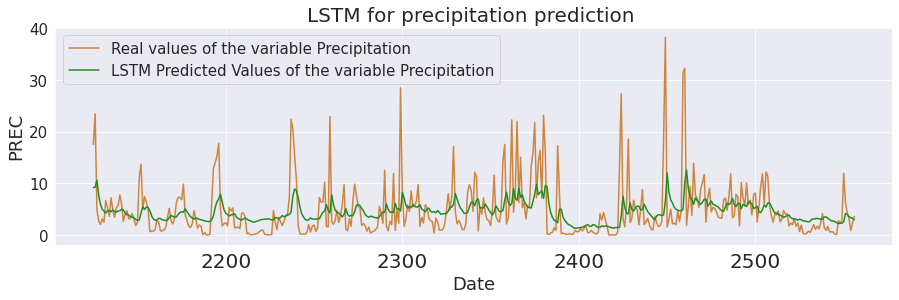

In [68]:

Forecastb1=pd.DataFrame({'Real values of the variable Precipitation':df1p[:433], 'LSTM Predicted Values of the variable Precipitation':rev2p})
# Forecastb1['date']=dates
# Forb1=Forecastb1.set_index('date')
Forecastb1.plot.line(figsize=(15, 4),color=['peru','forestgreen'])
plt.ylabel("PREC",fontsize=18)
plt.xlabel("Date",fontsize=18)

plt.title("LSTM for precipitation prediction ")
plt.legend(fontsize=15)
plt.savefig('LSTM_TMP_PREDx.png')
files.download("LSTM_TMP_PREDx.png")
plt.show()

# BIDIRECTIONAL LSTM

In [ ]:
########################################################################################################################
#####################################  Bi-LSTM model for   Precipitation prediction       ##############################
########################################################################################################################

model2= keras.Sequential()
model2.add(
    layers.Bidirectional(layers.LSTM(194, return_sequences=False), input_shape=(window_length, features_num))
)
model2.add(layers.Dense(1))
model2.summary()
# Early stopping: Model stops if the validation loss does not improve after 3 more iteration the algorithm stop
early_stopping1= tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,mode='min')
model2.compile(loss=tf.losses.MeanSquaredError(),optimizer='adam',metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.RootMeanSquaredError()])
history2=model2.fit(train_generator,epochs=95,shuffle=False, validation_data=val_generator,callbacks=[early_stopping1])



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 388)              313504    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 389       
                                                                 
Total params: 313,893
Trainable params: 313,893
Non-trainable params: 0
_________________________________________________________________
Epoch 1/95
51/51 [==============================] - 9s 82ms/step - loss: 0.0200 - mean_absolute_error: 0.1066 - root_mean_squared_error: 0.1414 - val_loss: 0.0064 - val_mean_absolute_error: 0.0442 - val_root_mean_squared_error: 0.0802
Epoch 2/95
51/51 [==============================] - 3s 65ms/step - loss: 0.0072 - mean_absolute_error: 0.0568 - root_mean_squared_error: 0.0850

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

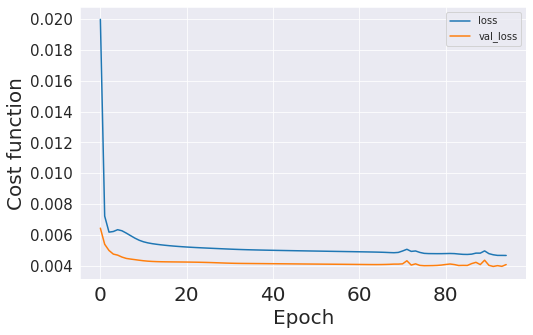

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

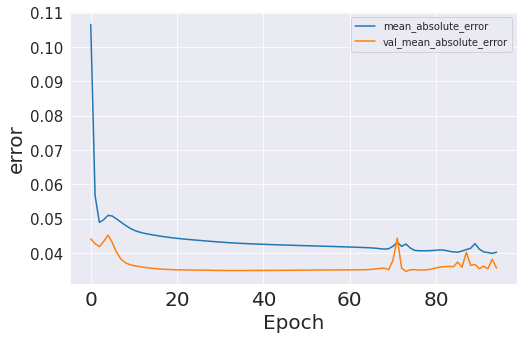

In [ ]:
# Learning Curves

pd.DataFrame(history2.history)[['loss','val_loss']].plot(figsize=(8,5))
plt.ylabel("Cost function")
plt.xlabel("Epoch")
plt.savefig('Bi-LSTM_PREC_LOSS.png')
files.download("Bi-LSTM_PREC_LOSS.png")
plt.show()
pd.DataFrame(history2.history)[['mean_absolute_error','val_mean_absolute_error']].plot(figsize=(8,5))
plt.ylabel("error")
plt.xlabel("Epoch")
plt.savefig('Bi-LSTM_PREC_ERROR.png')
files.download("Bi-LSTM_PREC_ERROR.png")
plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

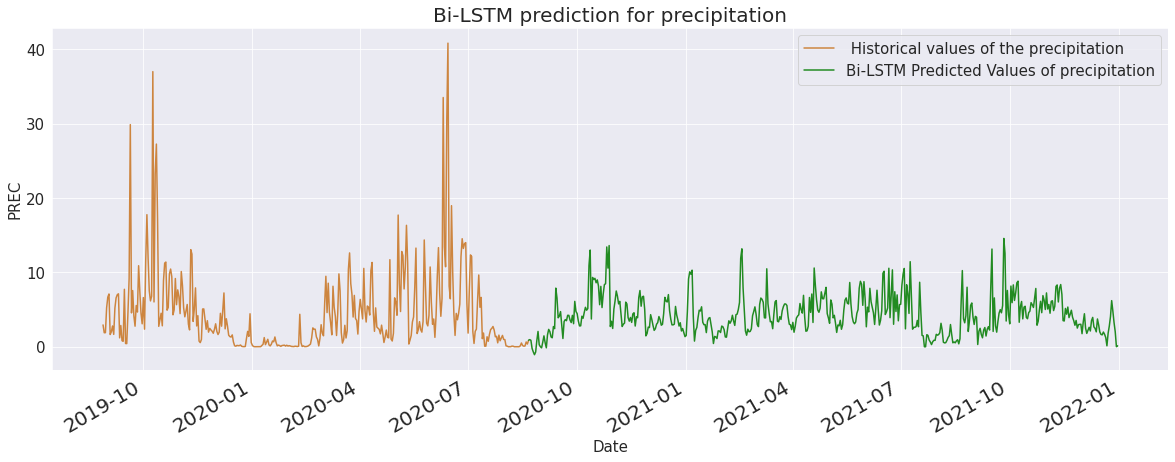

In [ ]:
# Predictions
prediction2=model2.predict(test_generator)
# Consider the values of X_test by ignoring the first 14th
New_X_test2=X_test[:,1:][window_length:]

# Datapredicted
df_pred12=pd.concat([pd.DataFrame(prediction2),pd.DataFrame(New_X_test2)],axis=1)

# return the inverse transform of the MinMaxscaler created above to give the real value that we had initially
rev_trans12=scaler.inverse_transform(df_pred12)
# rev_trans1


# Dysplay the prediction set
df_final12=df_input[-prediction2.shape[0]:]
df011=df_final12['PREC']
rev022=rev_trans12[:,0]

#  Plot of historical and predicted values



dates = pd.date_range('08/21/2020', periods=498)
dates1 = pd.date_range('01/01/2015', periods=2060)
Forecastb=pd.DataFrame({'Bi-LSTM Predicted Values of precipitation':rev022})
Forecastb['date']=dates
Forb=Forecastb.set_index('date')
T=df_input['PREC']
D1=T[0:2060].to_frame(' Historical values of the precipitation')
D1['Date']=dates1
DD1=D1.set_index('Date')
train_forecast1 = pd.concat([DD1,Forb])
train_forecast1[1700:2600].plot.line(figsize=(20, 7),color=['peru','forestgreen'])
plt.ylabel("PREC",fontsize=15)
plt.xlabel("Date",fontsize=15)
# train_forecast.plot.line(figsize=(35, 7))
plt.title("Bi-LSTM prediction for precipitation")
plt.legend(fontsize=15)
plt.savefig('Bi-LSTM_PREC_PRED.png')
files.download("Bi-LSTM_PREC_PRED.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

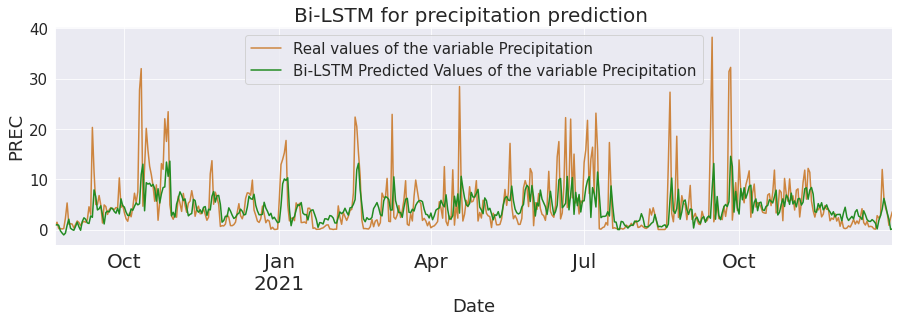

In [ ]:
# Plot of predicted values vs real observations



Forecastb1=pd.DataFrame({'Real values of the variable Precipitation':df011, 'Bi-LSTM Predicted Values of the variable Precipitation':rev022})
Forecastb1['date']=dates
Forb1=Forecastb1.set_index('date')
Forb1.plot.line(figsize=(15, 4),color=['peru','forestgreen'])
plt.ylabel("PREC",fontsize=18)
plt.xlabel("Date",fontsize=18)
plt.title("Bi-LSTM for precipitation prediction ")
plt.legend(fontsize=15)
plt.savefig('LSTM_TMP_PREDx.png')
files.download("LSTM_TMP_PREDx.png")
plt.show()

In [ ]:
# Performance metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error
mse1 = mean_squared_error(df011, rev022)
r2_1 = r2_score(df011, rev022)
mae1 = mean_absolute_error(df011, rev022)
# mae1_scaled1 = mean_absolute_error(X_test[-df_pred.shape[0]:,0], prediction[:,0])
mape1 = mean_absolute_percentage_error(df011, rev022)
print("mse=", mse1)
print("r2=", r2_1)
print("mae=", mae1)
# print("mae_scaled=" + str(round(mae1_scaled1,2)))
print("mape=",mape1)


mse= 23.769260265791004
r2= 0.2375336694885113
mae= 2.9020178979727995
mape= 30904711061368.832
